In [253]:
import torch
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torchvision import datasets, transforms, utils

In [254]:
batch_size = 128

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((256, 256))
])

train_set = datasets.ImageFolder(
    root='../archive/fruits-360-original-size/fruits-360-original-size/Training',
    transform=transform
)

validation_set = datasets.ImageFolder(
    root='../archive/fruits-360-original-size/fruits-360-original-size/Validation',
    transform=transform
)

test_set = datasets.ImageFolder(
    root='../archive/fruits-360-original-size/fruits-360-original-size/Test',
    transform=transform
)

trainloader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True)

testloader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=False)

validationloader = torch.utils.data.DataLoader(validation_set, batch_size=batch_size, shuffle=False)

In [255]:
train_set

Dataset ImageFolder
    Number of datapoints: 11871
    Root location: ../archive/fruits-360-original-size/fruits-360-original-size/Training
    StandardTransform
Transform: Compose(
               ToTensor()
               Resize(size=(256, 256), interpolation=bilinear, max_size=None, antialias=warn)
           )

In [256]:
test_set

Dataset ImageFolder
    Number of datapoints: 8750
    Root location: ../archive/fruits-360-original-size/fruits-360-original-size/Test
    StandardTransform
Transform: Compose(
               ToTensor()
               Resize(size=(256, 256), interpolation=bilinear, max_size=None, antialias=warn)
           )

In [257]:
validation_set

Dataset ImageFolder
    Number of datapoints: 3114
    Root location: ../archive/fruits-360-original-size/fruits-360-original-size/Validation
    StandardTransform
Transform: Compose(
               ToTensor()
               Resize(size=(256, 256), interpolation=bilinear, max_size=None, antialias=warn)
           )

In [258]:
classes = train_set.classes
print(classes)
print('Class size:', len(classes))

['apple_6', 'apple_braeburn_1', 'apple_crimson_snow_1', 'apple_golden_1', 'apple_golden_2', 'apple_golden_3', 'apple_granny_smith_1', 'apple_hit_1', 'apple_pink_lady_1', 'apple_red_1', 'apple_red_2', 'apple_red_3', 'apple_red_delicios_1', 'apple_red_yellow_1', 'apple_rotten_1', 'cabbage_white_1', 'carrot_1', 'cucumber_1', 'cucumber_3', 'dtd', 'eggplant_violet_1', 'pear_1', 'pear_3', 'zucchini_1', 'zucchini_dark_1']
Class size: 25


In [259]:
images, labels = next(iter(trainloader)) 
print("images-size:", images.shape)

out = utils.make_grid(images)
print("out-size:", out.shape)

images-size: torch.Size([128, 3, 256, 256])
out-size: torch.Size([3, 4130, 2066])


In [260]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 8, 5, 1)
        self.pool = nn.MaxPool2d(2)
        #self.dropout1 = nn.Dropout2d(0.25)
        #self.dropout2 = nn.Dropout2d(0.5)
        self.conv2 = nn.Conv2d(8, 16, 5, 1)
        self.conv3 = nn.Conv2d(16, 32, 5, 1)
        self.fc1 = nn.Linear(59536, 120)
        self.fc2 = nn.Linear(120, 47)
        #self.fc2 = nn.Linear(32, 47)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        #x = self.dropout1(x)
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        #x = self.dropout2(x)
        x = self.fc2(x)
        return x

In [261]:
net = CNN()
print(net)

CNN(
  (conv1): Conv2d(3, 8, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(8, 16, kernel_size=(5, 5), stride=(1, 1))
  (conv3): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=59536, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=47, bias=True)
)


In [262]:
import torch.optim as optim

device = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")
print('Device:', device)

model = CNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay=1e-8)

Device: cuda


In [263]:
from torch.utils.tensorboard import SummaryWriter

#train_writer = SummaryWriter("train_0409_0429")

num = 5
train_avg_loss = 0
total_step = len(trainloader)
train_loss = []
train_accuracy = []

val_loss = 0
validation_loss = []
validation_accuracy = []
valid_loss_min = np.Inf

for epoch in range(num):
    correct = 0
    total = 0
    tra_loss = 0.0
    for i, data in enumerate(trainloader):
        # get the inputs
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        tra_loss += loss.item()
        _,pred = torch.max(outputs, dim=1)
        correct += (pred == labels).sum().item()
        total += labels.size(0)

        if i % 50 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss {:.6f}'.format(
                epoch, i * len(inputs), len(trainloader.dataset), 
                100. * i / len(trainloader), loss.item()))

    #train_accuracy = 100 * correct / total
    accuracy = 100 * correct / total
    train_accuracy.append(accuracy)
    train_loss.append(tra_loss/total_step)
    print('Accuracy of the network on training: %d %%' % (accuracy))
    print('Loss of the network on training:', np.mean(train_loss))

    #train_writer.add_scalar('Loss/train', loss, epoch)
    #train_writer.add_scalar('Accuracy/train', train_accuracy, epoch)

    with torch.no_grad():
        model.eval()
        for data in testloader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            loss = criterion(outputs, labels)
            val_loss += loss.item()

        #test_accuracy = 100 * correct / tota
        validation_accuracy.append(100 * correct / total)
        validation_loss.append(val_loss/len(testloader))
        network_learned = val_loss < valid_loss_min
        #print(f'validation loss: {np.mean(validation_loss):.4f}, validation acc: {(100 * correct / total):.4f}\n')
        #print('Accuracy of the network on testing: %d %%' % (test_accuracy))
        #print('Average Loss: %d %%' % (val_loss))
        print('Accuracy of the network on validation: %d %%' % (100 * correct / total))
        print('Loss of the network on validation:', (np.mean(validation_loss)))
        if network_learned:
            valid_loss_min = val_loss
            torch.save(net.state_dict(), 'model_parameter.pkl')
    model.train()
print('Finished Training')

Train Epoch: 0 [0/11871 (0%)]	Loss 3.882326
Train Epoch: 0 [6400/11871 (54%)]	Loss 0.397606
Accuracy of the network on training: 73 %
Loss of the network on training: 1.0319774639542385
Accuracy of the network on validation: 82 %
Loss of the network on validation: %d %% 0.18573005418664357
Improvement Detected
Train Epoch: 1 [0/11871 (0%)]	Loss 0.178577
Train Epoch: 1 [6400/11871 (54%)]	Loss 0.162114
Accuracy of the network on training: 94 %
Loss of the network on training: 0.5987763980864197
Accuracy of the network on validation: 94 %
Loss of the network on validation: %d %% 0.24564065380221017
Train Epoch: 2 [0/11871 (0%)]	Loss 0.224296
Train Epoch: 2 [6400/11871 (54%)]	Loss 0.095130
Accuracy of the network on training: 96 %
Loss of the network on training: 0.43395907158452657
Accuracy of the network on validation: 96 %
Loss of the network on validation: %d %% 0.2865603807510348
Train Epoch: 3 [0/11871 (0%)]	Loss 0.105963
Train Epoch: 3 [6400/11871 (54%)]	Loss 0.016939
Accuracy of th

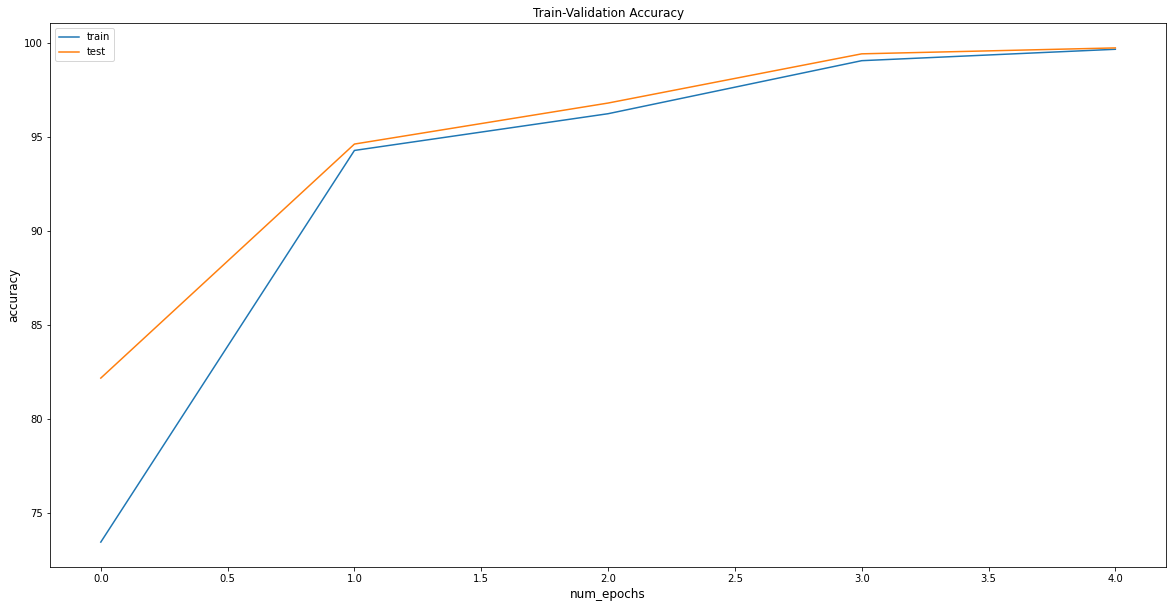

In [264]:
fig = plt.figure(figsize=(20,10))
plt.title("Train-Validation Accuracy")
plt.plot(train_accuracy, label='train')
plt.plot(validation_accuracy, label='test')
plt.xlabel('num_epochs', fontsize=12)
plt.ylabel('accuracy', fontsize=12)
plt.legend(loc='best')

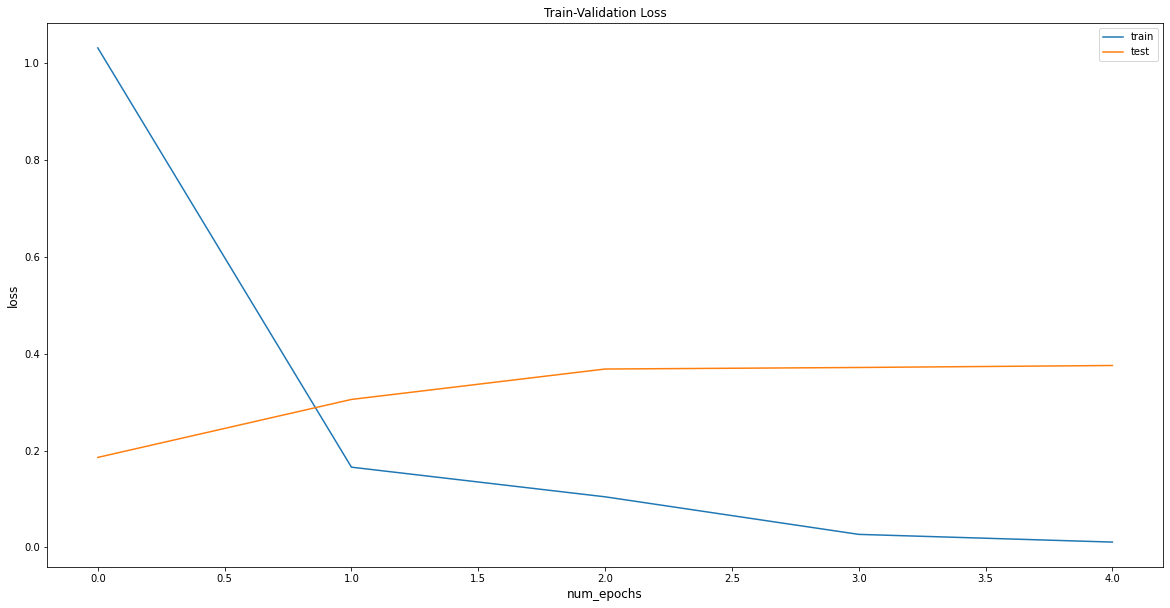

In [265]:
fig = plt.figure(figsize=(20,10))
plt.title("Train-Validation Loss")
plt.plot(train_loss, label='train')
plt.plot(validation_loss, label='test')
plt.xlabel('num_epochs', fontsize=12)
plt.ylabel('loss', fontsize=12)
plt.legend(loc='best')

Referennce:
1. Fruits 360 on Kaggle: https://www.kaggle.com/datasets/moltean/fruits
2. PyTorch Training a classifier: https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html
3. Define a Neural Network in PyTorch: https://pytorch.org/tutorials/recipes/recipes/defining_a_neural_network.html